In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
df = pd.read_csv('Problem1_DataSet.csv')
df.head(1)

,Month,"Miles, in Millions"
0,Jan-1964,7.269


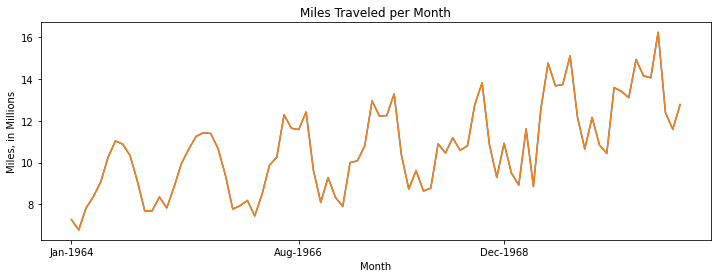

In [3]:
y = df.iloc[:,1]
X = df.iloc[:,0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(X, y)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Month')
plt.ylabel('Miles, in Millions')
plt.title('Miles Traveled per Month')
ax.plot(X, y)

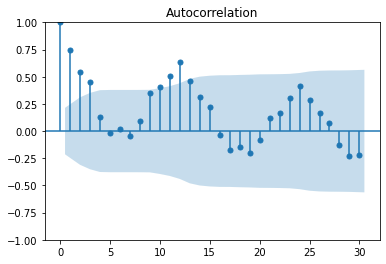

In [4]:
plot_acf(df['Miles, in Millions'], lags=30);

Seasonal period most likely 12 months

<AxesSubplot:>

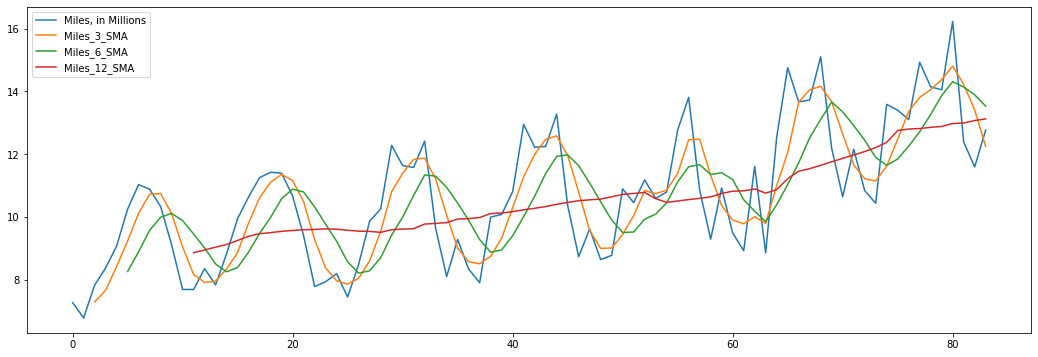

In [5]:
df2 = df.copy()
df2['Miles_3_SMA'] = df2['Miles, in Millions'].rolling(window=3).mean()
df2['Miles_6_SMA'] = df2['Miles, in Millions'].rolling(window=6).mean()
df2['Miles_12_SMA'] = df2['Miles, in Millions'].rolling(window=12).mean()
df2[['Miles, in Millions','Miles_3_SMA','Miles_6_SMA','Miles_12_SMA']].plot(figsize=(18,6))

12 month simple moving average best extracts the trend as its not as wavy as the 6 month.Trend is in increasing order.

c:\Users\jagac\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


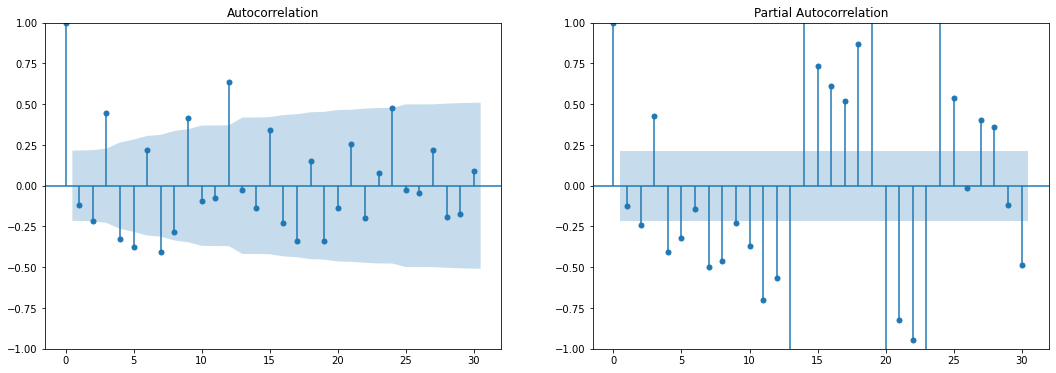

In [6]:
diff1 = df.iloc[:,1].diff().dropna()
fig, ax = plt.subplots(1,2,figsize=(18,6))
plot_acf(diff1, lags=30, ax=ax[0])
plot_pacf(diff1, lags=30, ax=ax[1])
plt.show()

We have quite a few significant lags such as 3,4,5,7,9,12 on ACF as well as most of the lags are significant on the PACF.

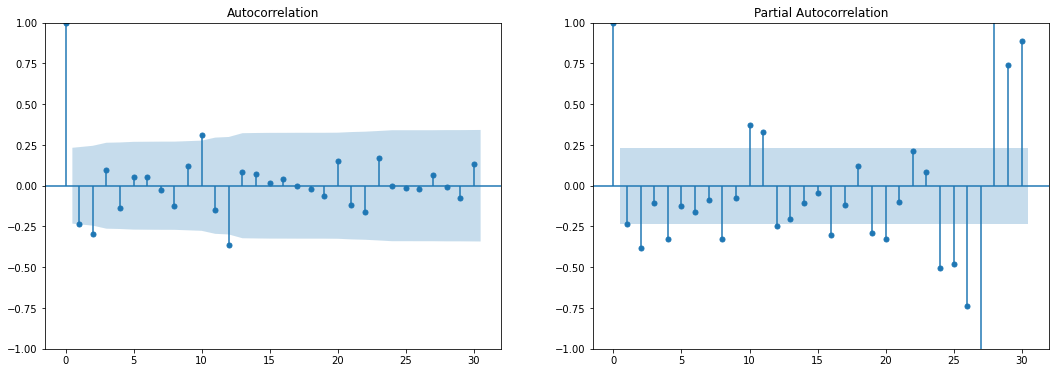

In [7]:
diff2 = diff1.diff(periods=12).dropna()
fig, ax = plt.subplots(1,2,figsize=(18,6))
plot_acf(diff2, lags=30, ax=ax[0])
plot_pacf(diff2, lags=30, ax=ax[1])
plt.show()

Significant lags on 1,2,10,12 for acf
1,2,4,10, 11 on pacf

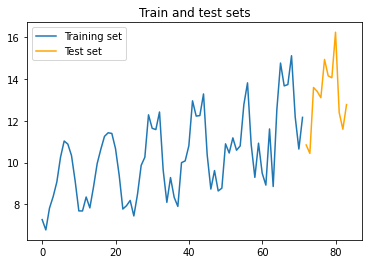

In [8]:
test_size = 12
df_train = df[:-test_size]
df_test = df[-test_size:]
plt.title('Train and test sets')
plt.plot(df_train['Miles, in Millions'], label='Training set')
plt.plot(df_test['Miles, in Millions'], label='Test set', color='orange')
plt.plot(figsize=(18, 4))
plt.legend();

In [9]:
'''
References for this one:
https://www.hackerrank.com/challenges/itertools-product/problem
https://www.youtube.com/watch?v=3ecISAkioPc
https://stackoverflow.com/questions/63402766/how-can-i-calculate-an-aic-value-for-a-statsmodels-linear-mixed-effects-model
https://stackoverflow.com/questions/50464241/returning-the-actual-index-value-of-max-min-values-from-a-pandas-dataframe-col
https://stackoverflow.com/questions/34444607/how-to-ignore-statsmodels-maximum-likelihood-convergence-warning

'''
# Ignore warnings 
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

# Create a combination of pdq and PDQm m=12 as identified before
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in pdq]
combos = []

for order in pdq:
    for seasonal_order in PDQ:
        try:
            model=SARIMAX(df_train['Miles, in Millions'],order=order,seasonal_order=seasonal_order)
            output = model.fit()
            combos.append([order, seasonal_order, output.aic, output.bic])
            
        except:
            continue

params = pd.DataFrame(combos, columns=['pdq','PDQm','AIC','BIC'])
print('Best parameters based on AIC')
print(params.loc[params['AIC'].idxmin()])
print('-'*80)
print('Best parameters based on BIC')
print(params.loc[params['BIC'].idxmin()])
# about 5 mins to run

Best parameters based on AIC
pdq         (0, 0, 1)
PDQm    (0, 2, 1, 12)
AIC         143.66814
BIC        149.281743
Name: 34, dtype: object
--------------------------------------------------------------------------------
Best parameters based on BIC
pdq         (0, 0, 1)
PDQm    (0, 2, 1, 12)
AIC         143.66814
BIC        149.281743
Name: 34, dtype: object


In [20]:
best_params = params.loc[params['AIC'].idxmin()]['pdq']

print(best_params)

(0, 0, 1)


In [10]:
model=SARIMAX(df_train['Miles, in Millions'],order=(0,0,1),seasonal_order=(0,2,1,12))
model = model.fit()
model_fcast = model.forecast(steps=12)

convert = np.array(model_fcast)
forecast_df = pd.DataFrame(convert, columns=['Preds'])

print(f"MSE: {mean_squared_error(model_fcast, df_test.drop(['Month'], axis= 1))}")
df_final = pd.concat([forecast_df, df_test], axis="columns",ignore_index=True)
df_final[['Preds','Miles, in Millions']].plot(figsize=(18,6))
plt.ylabel('Values')
plt.xlabel('Lags')
plt.title('Test vs Predictions')
plt.show

MSE: 2.029749420354519


KeyError: "None of [Index(['Preds', 'Miles, in Millions'], dtype='object')] are in the [columns]"

Does a poor job initially however it improves with every lag after 4th.

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 Miles, in Millions   No. Observations:                   72
Model:             SARIMAX(0, 0, 1)x(0, 2, 1, 12)   Log Likelihood                 -68.834
Date:                            Fri, 28 Oct 2022   AIC                            143.668
Time:                                    20:50:18   BIC                            149.282
Sample:                                         0   HQIC                           145.790
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6464      0.136      4.753      0.000       0.380       0.913
ma.S.L12      -0.9930     15.520     -0.064      0.949     -31.411      29.425
sigma2         0.6866     10.561      0.065      0.948     -20.012      21.385
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.41
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see the model starts making better forcasts, the further out they are.

In [ ]:
wine = pd.read_csv('TotalWine.csv')
wine.head(1)

,Time (Quarter),TotalWine
0,1,1.486


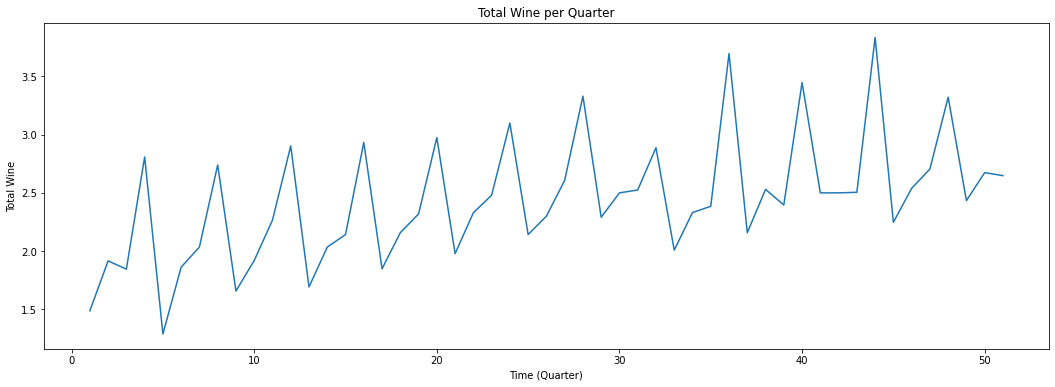

In [ ]:
y = wine.iloc[:,1]
X = wine.iloc[:,0]
fig, ax = plt.subplots(figsize=(18, 6))
plt.xlabel('Time (Quarter)')
plt.ylabel('Total Wine')
plt.title('Total Wine per Quarter')
ax.plot(X, y)


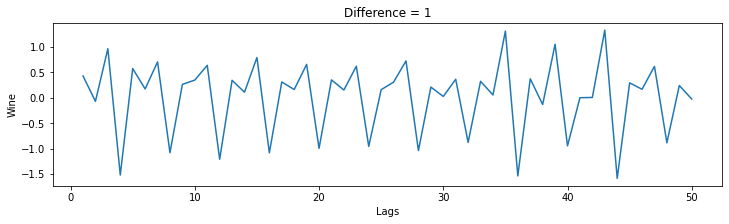

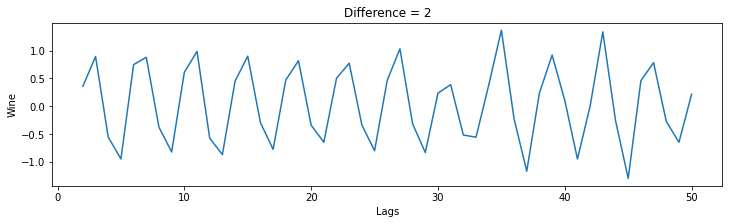

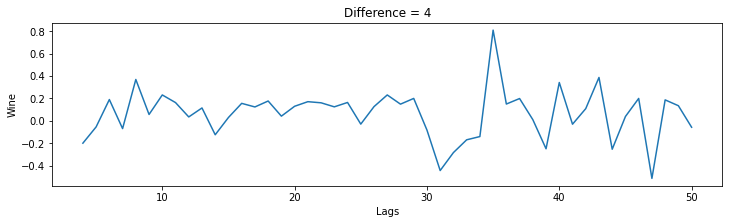

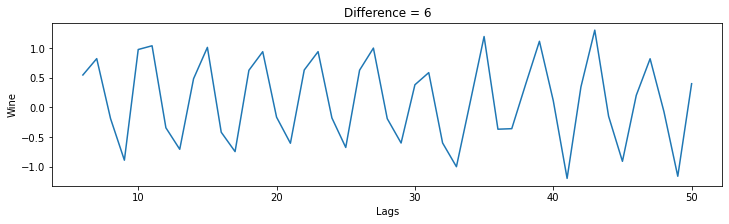

In [ ]:
seasonal_diff = [1, 2, 4, 6]
for diff_order in seasonal_diff:
    diff_itter = y.diff(periods=diff_order)
    
    fig, ax = plt.subplots(figsize=(12, 3))
    plt.title(f'Difference = {diff_order}')
    plt.ylabel('Wine')
    plt.xlabel('Lags')
    ax.plot(diff_itter)
    

Would prefer to use 4 as seasonal difference order as it does the best job removing seasonality.

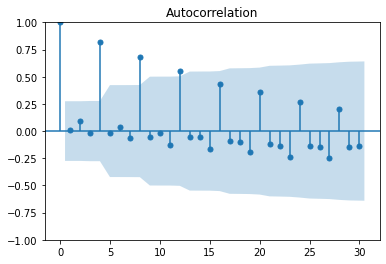

In [ ]:
plot_acf(y, lags=30);

Seasonal period is 4 as we get a spike in the acf.

In [ ]:
sel = ar_select_order(y, 10, ic='aic', seasonal=True, period = 4)
res = sel.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              TotalWine   No. Observations:                   51
Model:               Seas. AutoReg(3)   Log Likelihood                  18.589
Method:               Conditional MLE   S.D. of innovations              0.164
Date:                Fri, 28 Oct 2022   AIC                            -21.179
Time:                        20:50:25   BIC                             -6.209
Sample:                             3   HQIC                           -15.522
                                   51                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2123      0.259     -0.820      0.412      -0.720       0.295
s(2,4)           0.2823      0.235      1.199      0.230      -0.179       0.744
s(3,4)           0.4399      0.223      1.970      0.049       0.002       0.878
s(4,4)           1.4766      0.113     13.123      0.000       1.256       1.697
TotalWine.L1     0.2526      0.136      1.851      0.064      -0.015       0.520
TotalWine.L2     0.3196      0.132      2.417      0.016       0.060       0.579
TotalWine.L3     0.3039      0.136      2.235      0.025       0.037       0.570
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0657           -0.0000j            1.0657           -0.0000
AR.2           -1.0588           -1.4025j            1.7573           -0.3529
AR.3           -1.0588           +1.4025j            1.7573            0.3529
-----------------------------------------------------------------------------
"""

MAE: 0.11413220701982052


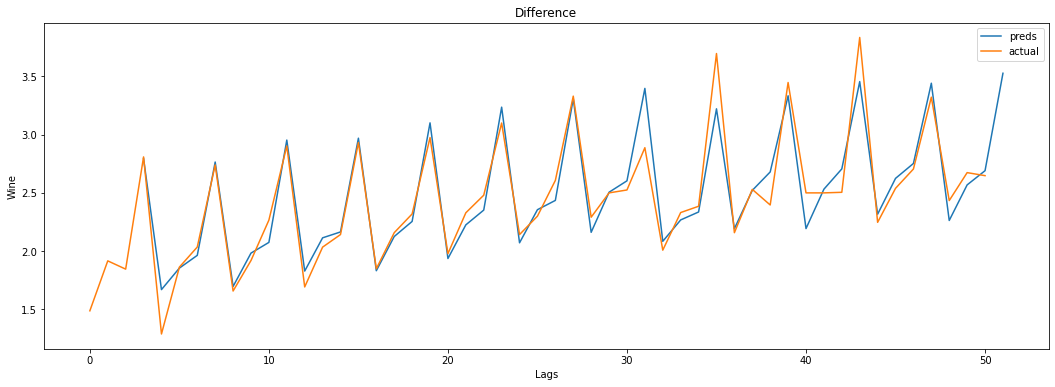

In [ ]:
mod = AutoReg(y, lags=3, seasonal=True, period=4)
mod_fit = mod.fit()
pred = mod_fit.predict(1, len(y))
print(f"MAE: {np.mean(np.abs(y - pred))}")

fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Difference')
plt.ylabel('Wine')
plt.xlabel('Lags')
ax.plot(pred, label= 'preds')
ax.plot(y, label = 'actual')
plt.legend(loc='upper right')
plt.show()